# Assignment 5

### GROUP NUMBER :
### STUDENT NAMES :
### STUDENT NUMBERS :

# Introduction
Knowledge of the location of a platform is essential for a lot of robotics applications. Assignement 3 demonstrated how to acquire a more abstract representation of linear structures perceived with a scanning range finder. This exercise will show that -given a map of the linear features in this representation- the robot can localize itself based on the linear structures it perceives. This exercise closely follows the example given in [p. 331-342]. We $\textbf{strongly}$ advice you to read the respective pages before starting with the exercise.

The robot considered throughout this assignment can be visualized by running the following cells. 

In [3]:
%pylab inline

from utils import *

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


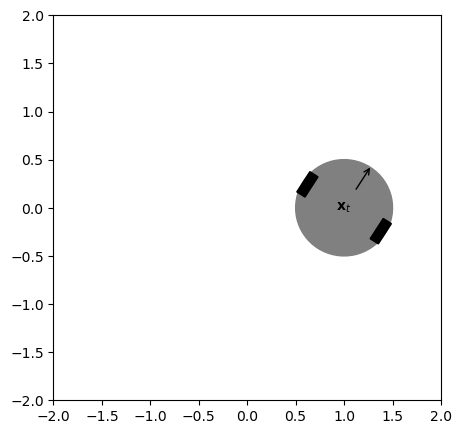

In [4]:
# Initialization of a figure
f, ax = plt.subplots(1,1, figsize=(5,5))
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)

# Initial state [x,y,theta]
x_0 = [1,0,1]
# Distance between the wheels
b = 1

# Plotting function to visualize the robot
draw_robot(x=x_0, b=b, label='${\\bf x}_{t}$')

# Kalman Filter Localization
The Extended Kalman Filter used for localization in this exercise can be structured into a prediction step and an update step. In the following, we will look at the two steps separately

## State Prediction
Given the knowledge of a state ${\bf x}_{t-1} = [x_{t-1}, y_{t-1}, \theta_{t-1}]^T$ at the previous time step and of the wheel displacement ${\bf u}_t=[\Delta s_l,\Delta s_r]^T$, where $\Delta s_l$ and $\Delta s_r$ are the wheel displacement of the left and right wheel respecitively.  The motion model can be employed to obtain a prior estimate of the current state. Here, we follow the order of ${\bf u}_t$ estabilished on [p. 337], which conflicts with the order stated on [p. 272]. Please consider any implications of this reversed order on the implementation of the functions and its Jacobians.

$$
\hat{\bf x}_t = f({\bf x}_{t-1}, {\bf u}_t) = {\bf x}_{t-1} + \begin{bmatrix}
(\Delta s_l + \Delta s_r)/2\cdot cos(\theta_{t-1}+(\Delta s_r - \Delta s_l)/2b)\\ 
(\Delta s_l + \Delta s_r)/2\cdot sin(\theta_{t-1}+(\Delta s_r - \Delta s_l)/2b)\\ 
(\Delta s_r - \Delta s_l)/b
\end{bmatrix}
\tag{1}
$$

It is reasonable to assume that the motion is subject to noise, which we choose to model as additive Gaussian noise $v\sim\mathcal{N}({\bf 0},{\bf Q})$ applied to the control input. As proposed in [p. 272], the noise on the control inputs can be modeled as independent for each wheel with a covariance proportional to the absolute value of the travelled distance, where a constant factor k is used to account for any non-deterministic effects.
$$
{\bf Q}=\begin{bmatrix}
k|\Delta s_l| & 0\\
0 & k|\Delta s_r|
\end{bmatrix}
\tag{2}
$$
Hence, an a priori estimate of the covariance of the state can be computed as
$$
\hat{P}_t = {\bf F}_x\cdot{\bf P}_{t-1}\cdot {\bf F}_x^T + {\bf F}_u\cdot{\bf Q}_{t}\cdot {\bf F}_u^T
\tag{3}
$$
where ${\bf F}_x$ and ${\bf F}_u$ denote the Jacobians of the motion model $f({\bf x}_{t-1},{\bf u}_t)$ with respect to the state estimate and the control inputs respectively. See also [p.270-272, 337]. And ${\bf P}_{t-1}$ denotes the covariance matrix in the previous time step ${\bf x}_{t-1}$.

## Task 1 (2 Points)
Write a function $\textit{transition\_function}({\bf x}_{t-1},{\bf u}_t, b)$ that accepts the previous state ${\bf x}_{t-1}$ of a differential drive robot as well as control inputs ${\bf u}_t$ and the inter wheel distance $b$ as arguments and computes an estimate of the current state $\hat{\bf x}_t$ as well as the Jacobians of the state transition function with respect to the state $\hat{\bf F}_x$ and the control input $\hat{\bf F}_u$ respectively:

In [5]:
def transition_function(x, u, b):
    '''
    Inputs:
        x: previous state at t-1
        u: control inputs
        b: wheel distance
    Return:
        x_next: estimate of the current state
        F_x: Jacobian of the transition function with respect to the state
        F_u: Jacobian of the transition function with respect to the control input
    '''

    # Check x and u have the correct dimensionality
    assert len(x) == 3
    assert len(u) == 2

    # Convert them to numpy arrays
    x = np.array(x)
    u = np.array(u)

    new_matrix = np.array([
        (u[1] + u[0])/2 * np.cos(x[2] + ((u[1] - u[0]) / 2 * b)),
        (u[1] + u[0])/2 * np.sin(x[2] + ((u[1] - u[0]) / 2 * b)),
        (u[1] - u[0]) / b
    ])

    x_next = x + new_matrix

    F_x = np.array([ # Jacobian of the transition function with respect to the state
        [1, 0, -((u[1] + u[0])/2 * np.sin(x[2] + ((u[1] - u[0]) / 2 * b)))],
        [0, 1, ((u[1] + u[0])/2 * np.cos(x[2] + ((u[1] - u[0]) / 2 * b)))],
        [0, 0, 1]
    ])

    row1_1 = 1/2 * np.cos(x[2] + ((u[1] - u[0]) / (2 * b))) + ((u[1] + u[0])/2) * -np.sin(x[2] + ((u[1] - u[0]) / 2 * b)) * (-1/(2*b))
    row1_2 = 1/2 * np.cos(x[2] + ((u[1] - u[0]) / (2 * b))) + ((u[1] + u[0])/2) * -np.sin(x[2] + ((u[1] - u[0]) / 2 * b)) * (1/(2*b))
    row2_1 = 1/2 * np.sin(x[2] + ((u[1] - u[0]) / (2 * b))) + ((u[1] + u[0])/2) * np.cos(x[2] + ((u[1] - u[0]) / 2 * b)) * (-1/(2*b))
    row2_2 = 1/2 * np.sin(x[2] + ((u[1] - u[0]) / (2 * b))) + ((u[1] + u[0])/2) * np.cos(x[2] + ((u[1] - u[0]) / 2 * b)) * (1/(2*b))


    F_u = np.array([ # Jacobian of the transition function with respect to the control input
        [row1_1, row1_2],
        [row2_1, row2_2],
        [-1/b, 1/b]
    ])

    # Check the dimensionality of the output
    assert x_next.shape == (3,)
    assert F_x.shape == (3,3)
    assert F_u.shape == (3,2)

    return x_next, F_x, F_u

In order to test your function, we consider a robot with state ${\bf x}_{t-1}$ and covariance ${\textbf P}_{t-1}$.
The robot is instructed to move by ${\bf u}_t=[\Delta s_l, \Delta s_r]$, where $\Delta s_l$ and $\Delta s_r$ represent the displacement for left and right wheel respectively. Since the motion is subject to noise, the actual displacement $\tilde{\bf u}_t$ is sampled from a multivariate Gaussian distribution $\mathcal{N}({\bf u}_t, {\bf Q})$. As a consequence, the robot state after its movement $\tilde{\bf x}_{t}$ might not correspond the the robot estimate $\hat{\bf x}_{t}$.

The following code visualizes the robot state ${\bf x}_{t-1}$ together with its actual position $\tilde{\bf x}_{t}$ after performing the noisy instruction $\tilde{\bf u}_t$. The same instruction is repeated independently for a total of $N=100$ times, and each resulting $\tilde{\bf x}_{t}$ is plotted as a red dot in the picture below. The robot estimated position after the movement $\hat{\bf x}_{t}$ and its respective covariance $\hat{\bf P}_t$ are visualized with a level-set plot in which position that have high probability are enclosed by a yellow line, while blue contours indicate regions of lower probability.

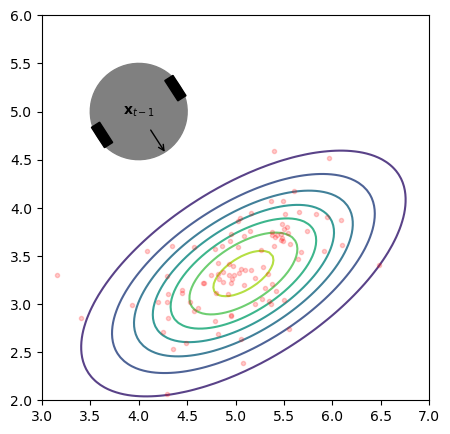

In [6]:
# Set up for the matplotlib figure
f, ax = plt.subplots(1,1, figsize=(5,5), sharex=True, sharey=True)
ax.set_xlim(3,7)
ax.set_ylim(2,6)

# Distance between the wheels
b = 1

# Robot state [x, y, theta] at time t-1
x = [4., 5., -1.]

# Covariance matrix for state at t-1
P = np.eye(3) * 0.1

# Draw the robot
draw_robot(x, b, label='${\\bf x}_{t-1}$')

# Amount of desired displacement for the two wheels [left_wheel, right_wheel]
# You can change this two values to test your function
u = [2, 2]

# Amount of noise for the robot movement
k = 0.1

# Perform N=100 experiments by initializing the robot at state x and performing the noisy movement
draw_simulation(x, P, u, k, b, N=100)

# Use transition_function to determine the estimated next state and the Jacobians F_x and F_u
x_next, F_x, F_u = transition_function(x, u, b)

# Determine the covariance matrix for the nosy movement Q following Equation (2)
Q = compute_Q(u, k)

# The covariance at time t is obtained using Equation (3)
P_next = F_x @ P @ F_x.T + F_u @ Q @ F_u.T

# Draw the distribution corresponding to the next state
draw_state_distribution(x_next, P_next)

$\textit{Hint:}$
When your implementation of $\textit{transition\_function}$ is correct, the red dots in the picture above should be roughly enclosed by the countour lines. Try to slighly change the value of ${\bf u}_t$ and ${\bf x}_{t-1}$ to check the correctness of your implementation. 
1. If the center of predictive distribution is in the wrong position check your computation for ${\bf x}_t$. 
2. If the direction of the contour lines does not match the distribution of the red dots, check your implementation for ${\bf F_x}$ and ${\bf F_u}$

Make sure your implementation is correct before starting $\textbf{Task 4}$

## Measurement function

For the remainder of this exercise, a map of the environment ${\bf M}$ is represented by a list of $K$ individual entries ${\bf m}^i$. As introduced in Assignment 3, lines can be parametrized as ${\bf m}^i =[\alpha^i,\rho^i]^T$. This parametrization will be applied to both, the output of our perception system $z_t$ as well as the entries of the map ${\bf M}$. Note however, that while the parametrization is identical, the coordinate frames in which the measurements and the map are represented differ. While lines in the map are represented in the world coordinate frame, the robot senses lines in its $\textit{body coordinate frame}$ relative to its own varying pose $\hat{\mathbf{x}}_t$. Hence, the measurements can be modelled by transforming the lines in the map from the world coordinate frame into the body coordinate frame. A more detailed description of this transformation is given in [p. 338-340]. 

## Task 2 (1 Points)
Write a $\textit{measurement\_function}(\hat{\bf x}_t, {\bf m}_i)$ that accepts an a priori estimate of the state $\hat{\bf x}_t$ and a map entry ${\bf m}_i$ and that models a measurement $\hat{\bf z}_t$ as it would be perceived by a robot with state $\hat{\bf x}_t$, which constitutes the transformation from the world coordinate frame into the body coordinate frame of the robot. Additionally, compute the Jacobian of the measurement model $\hat{\bf H}_{\bf x}$ with respect to the state.  
Hint: In Assignment 3 we saw the difference between a point $[x, y]$ and a line $[\alpha, \rho]$ can be computed as
$
\text{Difference} = \rho-x \cos \alpha-y \sin \alpha
$

In [7]:
def measurement_function(x, m):
    '''
    Inputs:
        x: estimate of the state at time t
        m: map entry
    Return:
        z: measurement as perceived by a robot with state x
        H: Jacobian of the measurement model with respect to the state
    '''

    # Converting x and m to numpy arrays
    x = np.array(x)
    m = np.array(m)

    alpha, rho = m[0], m[1]

    # Compute the measurement z
    z = np.array([
        alpha - x[2],
        rho - (x[0] * np.cos(alpha) + x[1] * np.sin(alpha))
    ])

    H = np.array([
        [0, 0, -1],
        [-np.cos(alpha), -np.sin(alpha), 0]
    ])

    # TODO: this is hard coded to show the correct answer in the example
    # Remove everything up to ################## and replace it with your implementation

    # if np.linalg.norm(m - np.array([0, 7])) == 0:
    #     z = [-1.,  3.]
    # elif np.linalg.norm(m - np.array([1.5707963267948966, 7])) == 0:
    #     z = [0.57079633, 2.        ]
    # elif np.linalg.norm(m - np.array([1.5707963267948966, 1])) == 0:
    #     z = [0.57079633, -4.]
    # elif np.linalg.norm(m - np.array([0, 2])) == 0:
    #     z = [-1., -2.]
    # elif np.linalg.norm(m - np.array([0.7853981633974483, 4])) == 0:
    #     z = [-0.21460184, -2.36396103]
    # else:
    #     z = [0, 0]rm(m - np.array([0, 7])) == 0:
    #     z = [-1.,  3.]
    # elif np.linalg.nor

    # z = np.array(z)
    # H = np.zeros([2,3])

    ##################

    # Checking the shape of the outputs
    assert z.shape == (2,)
    assert H.shape == (2,3)

    return z, H

In this exercise, we are considering a map ${\bf M}$ consisting of a simple room with 5 walls. The following code visualizes the map in world coordinates together with the robot state ${\bf x}_t$, and the same map transformed into the robot body coordinates frame using your implementation of $\textit{measurement\_function}$ together with the robot measurements ${\bf Z}$.

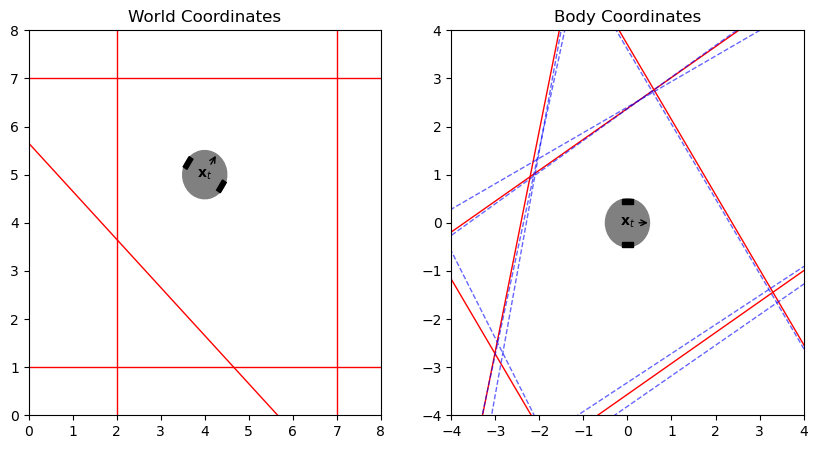

In [8]:
# Figure Setup
f, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].set_title("World Coordinates")
ax[0].set_xlim(0,8)
ax[0].set_ylim(0,8)

ax[1].set_title("Body Coordinates")
ax[1].set_xlim(-4,4)
ax[1].set_ylim(-4,4)

# Distance between the wheels
b = 1

# Robot state [x, y, theta]
x = [4., 5., 1.]

# Draw the robot on the two subplots
draw_robot(x, b, label='${\\bf x}_t$', ax=ax[0]) # World coordinates
draw_robot([0,0,0], b, label='${\\bf x}_t$', ax=ax[1]) # Body frame coordinates

# Map M, each entry represents one line in polar coordinates
M = get_default_map()

# Draw the map in world coordinates on the first picture
draw_map(M, ax=ax[0])

# Initialize an empty map in robot body coordinate frame
robot_M = []

# Use the measurement_function to convert the global coordinates m into local ones z
for m in M:
    z, H = measurement_function(x, m)
    robot_M.append(z)


# Draw the map in body frame coordinates on the second picture
draw_map(robot_M, ax=ax[1])

# Take some measurements Z using the robot sensors
Z, R = make_measurements(x, M)

# Draw the robot measurements on the second picture
draw_map(Z,  color='blue', dashed=True, ax=ax[1], alpha=0.6)

$\textit{Hint:}$ 
When your implementation of $\textit{measurement\_function}$ is correct, the red lines in the right picture (corresponding to the map in body coordinate frame) should be close to the robot measurements (dashed blue lines in the picture). To test your implementation, you can change the value of the initial state ${\bf x}_t$ in the code above and check the consistancy between the red and blue lines.

Make sure your implementation is correct before progressing to the $\textbf{Task 3}$

## Measurement association
In order to apply the Kalman filter update correctly, associations between observations and map entries need to be established. To this end we employ the Mahalonobis distance between a predicted measurement $\hat{\bf z}_t^i$ and an observation ${\bf z}^j_t$. With the innovation $\bf{v}^{ij}_t$ as a measure of the difference between a predicted and observed measurement
$$
{\bf{v}}^{ij}_t = {\bf z}^i- \hat{\bf z}_t^j
$$
and the $\textit{estimation covariance } \boldsymbol{\Sigma}_{IN_t}^{ij}$
$$
\boldsymbol{\Sigma}_{IN_t}^{ij} = \hat{\bf H}_{\bf x}^{i}\cdot \hat{\bf P}_t \cdot \left(\hat{\bf H}_{\bf x}^{i}\right)^T + {\bf R}_t^j
$$
the Mahalanobis distance is calculated as
$$
d_t^{ij} = \left({\bf{v}}^{ij}_t\right)^T\cdot\left( \boldsymbol{\Sigma}_{IN_t}^{ij} \right)^{-1}{\bf{v}}^{ij}_t
$$
In real-world robotics application there will always be corrupting measurements that do not correspond to entries in the map. Hence, we introduce a $\textit{validation gate}\ g$ and only consider associations that fall into this gate $d_t^{ij}<g^2$. When multiple map entries fall into the validation gate of a single measurement, the measurement is associated with the entry with the smallest Mahalanobis distance. On the other hand, multiple measurements may be associated with a single map entry. Please find additional information in [p. 334-335, 340-342].


### Task 3 (3 points)
Write a $\textit{associate\_measurements}(\hat{\bf x}_t, \hat{\bf P}_t, {\bf Z}_t, {\bf R}_t, {\bf M}, g)$ function that accepts the a priory state estimate $\hat{\bf x}_t$ and its covariance $\hat{\bf P}_t$, $N$ measurements ${\bf Z}_t$ expressed as a list with $N$ entries $z^j$ and their corresponding covariance matrices ${\bf R}_t$ expressed as a list of $2\times 2$ matrices, as well as the map ${\bf M}$ and a scalar navigation gate $g$. The function returns a vector ${\bf a}$ with $N$ entries, corresponding to the association between measurements ${\bf z}_j$ and map entries ${\bf m}_i$. In particular, each entry $a^j$ contains $i$ if the minimum distance $d^{ij}_t<g^2$, $-1$ otherwise:
$$
a^j =\begin{cases}
\text{arg}\min_i d_t^{ij}\ \ \ \text{if } \min_i d_t^{ij}<g^2\\
-1\ \ \ \text{otherwise}
\end{cases}
$$

In [9]:
def associate_measurements(x, P, Z, R, M, g):
    '''
    Inputs:
        x: estimate of the state at time t
        P: covariance of the state estimate
        Z: list of measurements
        R: list of covariance matrices corresponding to the measurements (R[i] is the covariance for Z[i])
        M: list of map entries in world coordinates
        g: validation gate
    Return:
        a: vector of associations between measurements and map entries
    '''

    # Hint: you can use 'np.linalg.inv' to invert matrices

    # Initialize the association vector
    a = np.zeros(len(Z))
    matrix = []

    for m in M:
        z_est, H = measurement_function(x, m)
        distances = []

        for i in range(len(Z)):
            v = Z[i] - z_est
            est_cov = H @ P @ H.T + R[i]
            d = v.T @ np.linalg.inv(est_cov) @ v

            distances.append(d)

        matrix.append(distances)

    matrix = np.array(matrix)

    for i in range(len(matrix[0])):
        dis =[matrix[j][i] for j in range(len(matrix))]

        if np.min(dis) < g**2:
            a[i] = np.argmin(dis)
        else:
            a[i] = -1

    ##################

    # Check a has the one entry for each Z
    assert a.shape[0] == len(Z)

    return a.astype(int)

To visualize the result of the $\textit{associate\_measurements}$ function, we are going to plot each line in the map (continuous lines) and the corresponding associated measurements (dashed lines) with the same color if they are associated to each other according to ${\bf a}$. Measurements that are discarded by the validation gate $g$ are shown in black. Keep in mind that multiple measurements can be associated to the same map entry.

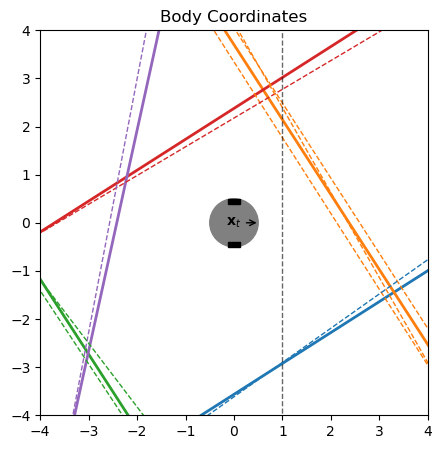

In [10]:
# Figure setup
f, ax = plt.subplots(1,1, figsize=(5,5))
ax.set_title("Body Coordinates")
ax.set_xlim(-4,4)
ax.set_ylim(-4,4)

# Distance between the wheels
b = 1

# Robot state [x, y, theta]
x = [4,5,1]

# Covariance matrix for the initial state
P = np.eye(3) * 0.1

# Draw the robot
draw_robot([0,0,0], b, label='${\\bf x}_t$', ax=ax)

# Validation gate g
g = 1

# Map M, each entry represents one line in polar coordinates
M = get_default_map()

# Use the measurement_function to convert the global coordinates m into local ones z
robot_M = []
for m in M:
    z, _ = measurement_function(x, m)
    robot_M.append(z)


# Take some measurements Z using the robot sensors
Z, R = make_measurements(x, M)

# Add a faulty entry to the measurements for testing
Z.append(np.array([0, 1]))
R.append(np.eye(2))

# Determine the association between measurement and map entries
a = associate_measurements(x, P, Z, R, M, g)

# Draw each line in the map and its associated measurements with the same color
# Note: Make sure your measurement_function is correct first
draw_associations(robot_M, Z, a)

$\textit{Hint:}$
The correct output for this section should look like [this](correct_association.png), try to change the initial robot state and the value of the validation gate to check that your implementation is correct. Make sure your implementation is working before progressing to $\textbf {Task 4}$.

## Updating the estimate

The previous task provided the essential building blocks for implementing the Extended Kalman Filter updates according to the well established equations. Information on the Exteded Kallman Filter can be found in [p. 335-336].

### Task 4 (3 Points)
Write a $\textit{filter\_step}({\bf x}_{t-1}, {\bf P}_{t-1}, {\bf u}_t, {\bf Z}_t, {\bf R}_t, {\bf M}, g, b)$ that accepts the previously introduced quantities and that performs a single complete filter step, consisting of the state propagation, measurement association and a subsequent state update. 

In [35]:
from scipy.linalg import block_diag


def compute_innovation(x, Z_all, R_all, M, a):
    '''
    Input:
        x: the estimated robot state at time t
        Z_all: list of robot measurements at time t
        R_all: list of covariance matrices corresponding to the measurements in Z_all
        M: map in global coordinates
        a: measurement-map association vector (as defined in the previous section)
    Returns:
        v: list of innovation vectors
        filtered_H: list of Jacobians H (one for each innovation)
        filtered_R: list of Covariance matrices R (one for each innovation)
    '''

    v = []
    filtered_R = []
    filtered_H = []

    # For each assignment
    for i in range(len(a)):

        # If the value is not -1 (the association has not been filtered by the validation gate)
        if a[i] >= 0:

            # Compute the expected measurement (robot body coordinates) and its Jacobian
            z_hat, H = measurement_function(x, M[a[i]])

            # Compute the innovation vector
            v_i = Z_all[i] - z_hat

            # Add the innovation v_i, the Jacobian H and the covariance R to their respective list
            v.append(v_i)
            filtered_R.append(R_all[i])
            filtered_H.append(H)

    return v, filtered_H, filtered_R


def filter_step(x, P, u, k, Z, R, M, g, b):
    '''
    Input:
        x: robot state at time t-1
        P: covariance matrix corresponding to the robot state at time t-1
        u: control inputs
        k: displacement noise factor (see Equation (2))
        Z: list of robot measurements at time t
        R: list of covariance matrices corresponding to the measurements in Z
        M: map in global coordinates
        g: validation gate
        b: distance between the wheels
    Returns:
        x_next: corrected estimation for the robot state at time t
        P_next: corrected covariance corresponding to x_next
    '''

    x, F_x, F_u = transition_function(x, u, b)
    
    Q = compute_Q(u, k)
    
    # The covariance at time t is obtained using Equation (3)
    P = F_x @ P @ F_x.T + F_u @ Q @ F_u.T
    
    # Hint 1: you can use the 'compute_innovation' function defined above
    # to extract a list of innovation vectors v, the corresponding measurement
    # Jacobians H and list of covariance matrices R once you have the assignment vector a

    a = associate_measurements(x, P, Z, R, M, g)
    v, filtered_H, filtered_R = compute_innovation(x, Z, R, M, a)

    # Hint 2: you can use 'block_diag' to transform a list of matrices into a single block-diagonal matrix
    # a list of matrices list = [A, B, C] can be converted to a block diagonal matrix with block_diag(*list)
    # See https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.linalg.block_diag.html for more details

    block_R = block_diag(*filtered_R)
    block_H = np.vstack(filtered_H)

    # Hint 3: you can use 'np.concatenate' to concatenate a list of vectors into a single one
    # See https://docs.scipy.org/doc/numpy/reference/generated/numpy.concatenate.html for more details

    x = np.array(x)
    v_concat = np.concatenate(v)

    # x_next = x + np.linalg.inv(block_H.T @ np.linalg.inv(block_R) @ block_H) @ block_H.T @ np.linalg.inv(block_R) @ v_concat
    # P_next = P - np.linalg.inv(block_H.T @ np.linalg.inv(block_R) @ block_H)
    
    ##################
    # Your Code Here #
    ##################

    K = P @ block_H.T @ np.linalg.inv(block_R + block_H @ P @ block_H.T)
    x_next = x + K @ v_concat
    P_next = P - K @ block_H @ P

    ##################

    return x_next, P_next

Starting from a state ${\bf x}_{t-1}$, we compare the distribution of the robot position before reading the sensors with the ones corrected after taking the measurements ${\bf Z}$ into account by using the Kalman filter implementation. Note that since the noisy displacement are sampled differently each time, this cell can result is different outputs if run multiple times.

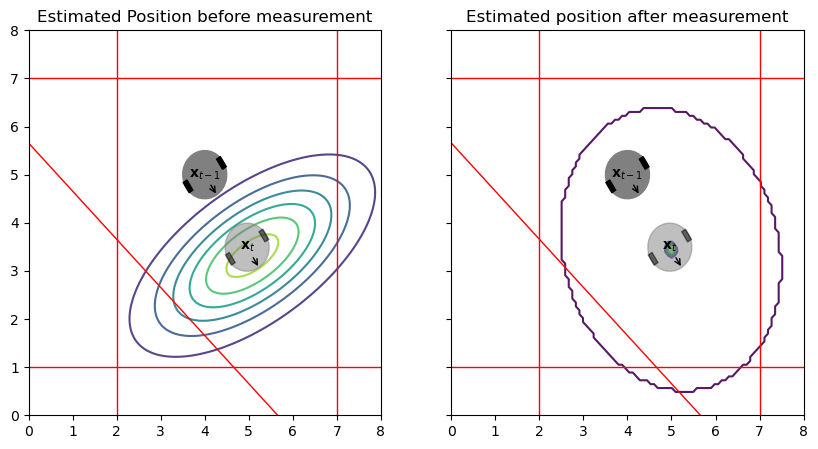

In [36]:
# Figure setup
f, ax = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)
ax[1].set_title('Estimated position after measurement')
ax[0].set_title('Estimated Position before measurement')
ax[0].set_xlim(0,8)
ax[0].set_ylim(0,8)

# Distance between the wheels
b = 1

# Robot state [x, y, theta] at time t-1
x = [4., 5., -1.]

# Covariance matrix for state at t-1
P = np.eye(3) * 0.5

# Draw the robot at time t-1 on both Axis
draw_robot(x, b, label='${\\bf x}_{t-1}$', alpha=1, ax=ax[0])
draw_robot(x, b, label='${\\bf x}_{t-1}$', alpha=1, ax=ax[1])

# Amount of desired displacement for the two wheels [left_wheel, right_wheel]
u = [2., 2.]

# Amount of noise in the robot movement see Equation (2)
k = 0.05

# Validation gate
g = 1

# Map M, each entry represents one line in polar coordinates
M = get_default_map()

# Draw the map on the two figures
draw_map(M, ax=ax[0])
draw_map(M, ax=ax[1])

# The actual initial robot position is sampled from the distribution at time t
x_actual = np.random.multivariate_normal(mean=x, cov=P)

# The position of the robot at the next timestamp is determined by executing the displacement determined by u
x_next = execute_instruction(x=x, u=u, b=b, k=k)

# Draw the robot at its actual position (noisy) at time t
draw_robot(x_next, ax=ax[0], label='${\\bf x}_{t}$', b=1, alpha=0.5)
draw_robot(x_next, ax=ax[1], label='${\\bf x}_{t}$', b=1, alpha=0.5)

# Determine the expected new position according to the transition function
x_next_est, F_x, F_u = transition_function(x, u, b)

# And compute its covariance matrix following Equation (2) and Equation (3)
Q = compute_Q(u, k)
P_next_est = F_x @ P @ F_x.T + F_u @ Q @ F_u.T

# Draw the distribution for the state at time t on the figure on the left
draw_state_distribution(x_next_est, P_next_est, ax=ax[0])

# Make some measurements in the current position
Z, R =  make_measurements(x_next, M)

# Use the implementation of Kalman filter to determine how to update x_next and P_next
x_next_kalman, P_next_kalman = filter_step(x, P, u, k, Z, R, M, g, b)

# Draw the distribution for the robot position after adjusting the estimates using the sensor input
draw_state_distribution(x_next_kalman, P_next_kalman, ax=ax[1])
plt.show()

### Hint:
The distribution of the robot position using the Kalman filter implementation should be more precise and have less variance compared to the open loop counterpart. See [this picture](Kalman_example.png) as an example of correct output. You can change the robot initial state, displacement and value of validation gate to check the correctness of your implementation

## Estimation of position over time (open-loop and Kalman filter)

### Sample data

You can also check your implementation by visualizing how the robot position is estimated over time. The following code executes 30 instructions sequentially. The actual robot position (in red) is compared against the open loop estimation (in blue) and with the Kalman filter update (in green).

In [ ]:
# Figure setup
f, ax = plt.subplots(1,1, figsize=(5,5), sharex=True, sharey=True)
ax.set_title('Robot Path')
ax.set_xlim(0,8)
ax.set_ylim(0,8)

# Initial state
x_0 = [3.,6.,-1]

# Initial covariance matrix
P_0 = np.eye(3) * 0.001

# Draw robot in its initial state
draw_robot(x_0, b, label='${\\bf x}_{0}$', alpha=1)

# List of displacements
U = [[0.1,0.105]] * 30 # the vector [0.1,0.105] is repeated 30 times

# Amount of noise in the robot movement see Equation (2)
k=0.05

# Validation Gate
g=1

# Map M, each entry represents one line in polar coordinates
M = get_default_map()

# Draw the map
draw_map(M)

# Initialize the values for the states and their estimation
x_actual = np.random.multivariate_normal(mean=x_0, cov=P_0)
x_ol = x_0
x_kalman = x_0

P_ol = P_0
P_kalman = P_0


# Lists to keep track of the estimation at different timestamps
actual_path = [x_actual]
ol_path = [x_0]
kalman_path = [x_0]

# For each displacement
for u in U:

    # Perform the instruction to determine the actual position
    x_actual = execute_instruction(x=x_actual, u=u, b=b, k=k)

    # Determine mean and covariance for the open loop update
    x_ol, F_x, F_u = transition_function(x_ol, u, b)
    Q = compute_Q(u, k)
    P_ol = F_x @ P_ol @ F_x.T + F_u @ Q @ F_u.T

    # Take measurements and compute mean and variance according to the Kalman update
    Z, R = make_measurements(x_actual, M)
    x_kalman, P_kalman = filter_step(x_kalman, P_kalman, u, k, Z, R, M, g, b)

    # Append the estimations to the respective histories
    actual_path.append(x_actual)
    ol_path.append(x_ol)
    kalman_path.append(x_kalman)

# Draw the three trajectories in different colors
draw_state_sequence(actual_path, color='red', alpha=0.2, label='Actual path')
draw_state_sequence(ol_path, color='blue', alpha=0.2, label='Open Loop')
draw_state_sequence(kalman_path, color='green', alpha=0.2, label='Kalman Filter')

# Update the legend opacity
leg = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# for lh in leg.legendHandles:
#     lh._legmarker.set_alpha(1)


The trajectory obtained by updating the estimates using sensor readings should generally match the actual one better than the open loop counterpart. See [this picture](Kalman_path.png) as an example.

### Simulation environment (CoppeliaSim)

You may also verify the quality of your implementation by estimating the position of a robot within CoppeliaSim simulated environment. Before running the following cells, make sure that "assignment_5_scene_1.ttt" scene is running in Coppelia environment.

In [ ]:
from coppelia_utils import SimulationRun, get_environment_map

You can modify the parameters of the run such as expected speed of the robot's wheel and additional measurement noise to examine the performance of your implementation in various scenarios. You play with the initial position of the robot in scene view of CoppeliaSim. 

In [ ]:
sim_run = SimulationRun()

M = get_environment_map(env_id=1)

g = 0.5 # validation gate
k = 0.1 # variance in wheel speed
speed_mean = np.array([1.2, 1.2]) # average speed of wheel rotation
measurement_noise = np.array([0.001, 0.0001]) # variance of noise added to detected lines (alpha, rho)
iter_steps = 20

true_path, ol_path, kalman_path = sim_run.run_simulation(
    transition_function=transition_function,
    kalman_step=filter_step,
    M=M, k=k, g=g, iter_steps=iter_steps,
    speed_mean=speed_mean, measurement_noise=measurement_noise)

In [ ]:
f, ax = plt.subplots(1,1, figsize=(5,5), sharex=True, sharey=True)
ax.set_title('Robot Path (in Coppelia)')
ax.set_xlim(-2.5,1.5)
ax.set_ylim(-1.5,1.5)

b = 0.2
draw_robot(true_path[0], b, label='${\\bf x}_{0}$', alpha=1)

draw_map(M)

draw_state_sequence(true_path, color='red', alpha=0.2, label='Actual path')
draw_state_sequence(ol_path, color='blue', alpha=0.2, label='Open Loop')
draw_state_sequence(kalman_path, color='green', alpha=0.2, label='Kalman Filter')

# Update the legend opacity
leg = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))